# Set Environment

In [ ]:
# Import the required module
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import warnings
import json
import seaborn as sns
warnings.filterwarnings("ignore")

In [ ]:
# Authenticate Google Drive, Google Cloud Platform & G-sheet
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
from google.cloud import bigquery
from gspread_dataframe import set_with_dataframe

import gspread
from oauth2client.client import GoogleCredentials
from google.auth import default
creds, _ = default()

import pandas_gbq
from tqdm import tqdm

auth.authenticate_user()
print('Authenticated')

In [ ]:
# GCP Project configuration
project_id = 'foodpanda-tw-bigquery'
client = bigquery.Client(project=project_id)

# Get SF experiment data



In [ ]:
df = client.query(f'''

DECLARE start_date DATE DEFAULT '2023-11-17';
DECLARE end_date DATE DEFAULT DATE_SUB(CURRENT_DATE('Asia/Taipei'), INTERVAL 2 DAY);

WITH all_sample AS (
  SELECT
    DISTINCT
    report_date,
    CASE
      WHEN dps_zone.name IN ('Beidou','Changhua','Erlin','Hemei','Huatan','Lukang','Shetou','Tianzhong','Xihu','Yuanlin') THEN 'Changhua'
      WHEN dps_zone.name IN ('Caotun','Nantou','Puli','Zhushan') THEN 'Nantou'
      WHEN dps_zone.name IN ('Chaozhou','Donggang','Hengchun','Kenting','Neipu','Pingtung','Wandan') THEN 'Pingtung'
      WHEN dps_zone.name IN ('Taipei east', 'Taipei west') THEN 'Taipei center'
      ELSE dps_zone.city_name END AS city,
    sessions.variant,
    sessions.perseus_client_id,
  FROM dps_sessions_mapped_to_perseus_sessions
  LEFT JOIN dps_zone
  LEFT JOIN event
  CROSS JOIN UNNEST(GENERATE_DATE_ARRAY(start_date, end_date)) AS report_date
  WHERE entity_id = 'FP_TW'
    AND DATE(perseus_session_created_at, 'Asia/Taipei') BETWEEN start_date AND end_date
    AND sessions.variant != 'Original'
    AND sessions.experiment_id BETWEEN 123 AND 137
    AND dps_zone.city_name IS NOT NULL
    AND dps_zone.city_name NOT IN ('Penghu', 'Taitung', 'Kinmen')
    AND event.vendor_group_id_in_test
    AND event.vertical_parent_in_test
)

, dps_test_order_raw AS (
  SELECT
    created_date_local,
    CASE
      WHEN zone_name IN ('Beidou','Changhua','Erlin','Hemei','Huatan','Lukang','Shetou','Tianzhong','Xihu','Yuanlin') THEN 'Changhua'
      WHEN zone_name IN ('Caotun','Nantou','Puli','Zhushan') THEN 'Nantou'
      WHEN zone_name IN ('Chaozhou','Donggang','Hengchun','Kenting','Neipu','Pingtung','Wandan') THEN 'Pingtung'
      WHEN zone_name IN ('Taipei east', 'Taipei west') THEN 'Taipei center'
      ELSE city_name END AS city,
    test_variant,
    platform_order_code AS order_code,
    perseus_client_id,
    COALESCE(gfv_local,0) AS gfv_in_local,
    COALESCE(service_fee_local,0) AS service_fee_in_local,
    COALESCE(revenue_local,0)-(COALESCE(delivery_costs_local,0)+COALESCE(voucher_dh_local,0)+COALESCE(discount_dh_local,0)) AS flgp,
    COALESCE(delivery_fee_local,0) AS delivery_fee_in_local
  FROM dps
  WHERE DATE(order_placed_at_local) BETWEEN start_date AND end_date
    AND is_own_delivery
    AND is_sent
    AND entity_id = 'FP_TW'
    AND vertical_type = 'restaurants'
    AND vendor_vertical_parent = 'Restaurant'
    AND is_in_treatment
    AND test_id BETWEEN 123 AND 137
    AND city_name IS NOT NULL
    AND city_name NOT IN ('Penghu', 'Taitung', 'Kinmen')
)

, dps_test_order_final AS (
  SELECT
    all_sample.city,
    all_sample.report_date,
    all_sample.variant AS test_variant,
    all_sample.perseus_client_id,
    dps_test_order_raw.order_code,
    dps_test_order_raw.gfv_in_local,
    dps_test_order_raw.service_fee_in_local,
    dps_test_order_raw.flgp,
    dps_test_order_raw.delivery_fee_in_local
  FROM all_sample
  LEFT JOIN dps_test_order_raw
         ON all_sample.city = dps_test_order_raw.city
        AND all_sample.report_date = dps_test_order_raw.created_date_local
        AND all_sample.perseus_client_id = dps_test_order_raw.perseus_client_id
)

SELECT
  city,
  test_variant,
  perseus_client_id,

  -- all
  COALESCE(COUNT(DISTINCT order_code),0) AS Orders_all,
  COALESCE(SUM(gfv_in_local),0) AS GFV_all,
  COALESCE(SAFE_DIVIDE(SUM(gfv_in_local),COUNT(DISTINCT order_code)),0) AS AFV_all,
  COALESCE(SUM(flgp),0) AS FLGP_all,
  COALESCE(SUM(service_fee_in_local),0) AS SF_all,
  COALESCE(SUM(delivery_fee_in_local),0) AS DF_all,

  -- weekend
  COALESCE(COUNT(DISTINCT CASE WHEN EXTRACT(DAYOFWEEK FROM report_date) IN (1,7) THEN order_code END),0) AS Orders_weekend,
  COALESCE(SUM(CASE WHEN EXTRACT(DAYOFWEEK FROM report_date) IN (1,7) THEN gfv_in_local END),0) AS GFV_weekend,
  SAFE_DIVIDE(
    SUM(CASE WHEN EXTRACT(DAYOFWEEK FROM report_date) IN (1,7) THEN gfv_in_local END),
    COUNT(DISTINCT CASE WHEN EXTRACT(DAYOFWEEK FROM report_date) IN (1,7) THEN order_code END)
  ) AS AFV_weekend,
  COALESCE(SUM(CASE WHEN EXTRACT(DAYOFWEEK FROM report_date) IN (1,7) THEN flgp END),0) AS FLGP_weekend,
  COALESCE(SUM(CASE WHEN EXTRACT(DAYOFWEEK FROM report_date) IN (1,7) THEN service_fee_in_local END),0) AS SF_weekend,
  COALESCE(SUM(CASE WHEN EXTRACT(DAYOFWEEK FROM report_date) IN (1,7) THEN delivery_fee_in_local END),0) AS DF_weekend,

  -- weekday
  COALESCE(COUNT(DISTINCT CASE WHEN EXTRACT(DAYOFWEEK FROM report_date) NOT IN (1,7) THEN order_code END),0) AS Orders_weekday,
  COALESCE(SUM(CASE WHEN EXTRACT(DAYOFWEEK FROM report_date) NOT IN (1,7) THEN gfv_in_local END),0) AS GFV_weekday,
  SAFE_DIVIDE(
    SUM(CASE WHEN EXTRACT(DAYOFWEEK FROM report_date) NOT IN (1,7) THEN gfv_in_local END),
    COUNT(DISTINCT CASE WHEN EXTRACT(DAYOFWEEK FROM report_date) NOT IN (1,7) THEN order_code END)
  ) AS AFV_weekday,
  COALESCE(SUM(CASE WHEN EXTRACT(DAYOFWEEK FROM report_date) NOT IN (1,7) THEN flgp END),0) AS FLGP_weekday,
  COALESCE(SUM(CASE WHEN EXTRACT(DAYOFWEEK FROM report_date) NOT IN (1,7) THEN service_fee_in_local END),0) AS SF_weekday,
  COALESCE(SUM(CASE WHEN EXTRACT(DAYOFWEEK FROM report_date) NOT IN (1,7) THEN delivery_fee_in_local END),0) AS DF_weekday

FROM dps_test_order_final
GROUP BY city, test_variant, perseus_client_id
ORDER BY city, test_variant, perseus_client_id
;

''').to_dataframe()
print("SQL completed! \n")


# Calculate the average metrics

In [ ]:
print(df)

In [ ]:
df.isna().sum()

In [ ]:
df.dtypes

In [ ]:
columns_to_exclude = ['city', 'test_variant', 'perseus_client_id']

# Select all numeric columns of data type "object"
df_numerical_columns = df.select_dtypes(include='object').columns.difference(columns_to_exclude)

# Convert all selected numerical columns to float
df[df_numerical_columns] = df[df_numerical_columns].apply(pd.to_numeric, errors='coerce')

In [ ]:
df_numeric_columns = df.select_dtypes(include=['number']).columns
df_avg = df.groupby(['city','test_variant'])[df_numeric_columns].mean().reset_index()

In [ ]:
df_avg

,city,test_variant,Orders_all,GFV_all,AFV_all,FLGP_all,SF_all,DF_all,Orders_weekend,GFV_weekend,AFV_weekend,FLGP_weekend,SF_weekend,DF_weekend,Orders_weekday,GFV_weekday,AFV_weekday,FLGP_weekday,SF_weekday,DF_weekday
0,Changhua,Control,2.579257,708.131777,138.694192,90.578469,9.954723,41.870106,0.935871,271.343939,291.908940,34.767583,3.796310,15.484212,1.643386,436.787838,268.218992,55.810886,6.158413,26.385894
1,Changhua,Variation1,2.64502,723.525698,138.310970,91.981568,10.491157,42.921178,0.949514,274.180766,291.805755,34.716509,3.955314,15.828804,1.695506,449.344932,268.122324,57.265059,6.535843,27.092373
2,Changhua,Variation2,2.6597,724.612052,138.704531,92.767001,10.645907,43.346740,0.960496,277.244801,291.406183,35.988478,4.046270,16.339324,1.699204,447.367252,267.395052,56.778523,6.599637,27.007416
3,Chiayi,Control,3.14938,864.102008,143.715677,103.871493,12.150502,47.927757,1.070587,304.925002,288.500642,34.466695,4.280362,16.661700,2.078793,559.177006,271.658902,69.404798,7.870139,31.266057
4,Chiayi,Variation1,3.098794,848.358055,143.231382,103.424779,12.293164,47.740220,1.063208,302.793716,287.239177,35.034710,4.375856,16.773627,2.035586,545.564339,271.988118,68.390069,7.917308,30.966592
5,Chiayi,Variation2,3.120828,859.801516,143.425429,105.525377,12.599635,47.948034,1.064386,305.117253,287.967687,35.538730,4.454316,16.861833,2.056442,554.684263,272.486162,69.986647,8.145319,31.086201
6,Hsinchu,Control,3.051978,919.613872,165.560367,90.141400,12.783961,42.311434,1.058443,329.946228,316.766294,32.282849,4.582965,15.152828,1.993535,589.667644,302.599343,57.858552,8.200996,27.158606
7,Hsinchu,Variation1,3.059156,915.688542,166.097756,90.006266,13.115074,43.168396,1.060453,328.373174,315.529919,32.324622,4.702804,15.394350,1.998703,587.315368,302.838617,57.681644,8.412270,27.774046
8,Hsinchu,Variation2,3.043469,917.104096,166.158554,90.895566,13.252462,42.684440,1.060867,330.818715,316.607890,32.732216,4.782151,15.357895,1.982602,586.285382,302.901130,58.163349,8.470312,27.326545
9,Hualien,Control,4.014432,1108.060726,171.179737,119.216343,15.595753,58.875615,1.368733,394.302574,294.280438,41.246564,5.531898,20.653249,2.6457,713.758151,276.769195,77.969779,10.063855,38.222366


# Conduct Welch's T Test with confidence interval

In [ ]:
# 安裝 pingouin
!pip install pingouin

In [ ]:
import pingouin as pg

In [ ]:
metric = list(df.columns[3:])
city = list(np.unique(df['city']))
variant_type = ['Variation1', 'Variation2']
test_result_df = pd.DataFrame(columns=['city','compare group','metric','T test p-value', 'T test low bound CI','T test high bound CI'])
i = 0

for c in city:
    for v in variant_type:
        for m in metric:
            city_filter = df['city'] == c
            control_filter = df['test_variant'] == 'Control'
            treatment_filter = df['test_variant'] == v
            control = list(df[city_filter & control_filter][m].astype('float64'))
            treatment = list(df[city_filter & treatment_filter][m].astype('float64'))
            if 'Orders' in m:
                t_test_result = pg.ttest(treatment, control, alternative='less', paired=False, correction=True, confidence=0.95)
            else:
                t_test_result = pg.ttest(treatment, control, alternative='two-sided', paired=False, correction=True, confidence=0.95)

            test_result_df.loc[i] = [c, f"Control vs {v}", m, t_test_result['p-val'][0], t_test_result['CI95%'][0][0], t_test_result['CI95%'][0][1]]
            i += 1

In [ ]:
test_result_df['T test p-value'] = round(test_result_df['T test p-value'],2)

In [ ]:
test_result_df

,city,compare group,metric,T test p-value,T test low bound CI,T test high bound CI
0,Changhua,Control vs Variation1,Orders_all,0.98,-inf,0.12
1,Changhua,Control vs Variation1,GFV_all,0.10,-3.01,33.80
2,Changhua,Control vs Variation1,AFV_all,0.69,-2.25,1.48
3,Changhua,Control vs Variation1,FLGP_all,0.34,-1.50,4.31
4,Changhua,Control vs Variation1,SF_all,0.00,0.28,0.80
...,...,...,...,...,...,...
571,Yunlin,Control vs Variation2,GFV_weekday,0.30,-8.92,28.78
572,Yunlin,Control vs Variation2,AFV_weekday,0.08,-6.85,0.38
573,Yunlin,Control vs Variation2,FLGP_weekday,0.09,-0.38,5.40
574,Yunlin,Control vs Variation2,SF_weekday,0.00,0.18,0.72


In [ ]:
test_result_df.isnull().sum()

In [ ]:
df_rounded = test_result_df.round(4)
df_no_nan = df_rounded.replace([np.inf, -np.inf], np.nan).fillna("NaN")

# Export result to gsheet

In [ ]:
# Insert to Google sheet
spreadsheet_url = 'https://docs.google.com/spreadsheets/link'
worksheet_title = 'df_avg'

In [ ]:
def df_insert_to_google_sheet(table, spreadsheet_url, worksheet_title):
  ''' Insert result data to the google sheet '''
  gc = gspread.authorize(creds)
  workbook = gc.open_by_url(spreadsheet_url)
  try:
    worksheet = workbook.worksheet(title=worksheet_title)
    workbook.del_worksheet(worksheet=worksheet)
  except:
    pass

  worksheet = workbook.add_worksheet(title=worksheet_title, rows=1, cols=1)
  set_with_dataframe(worksheet, df_avg)

In [ ]:
# result_df = processing_df(result_df, dynamic_dimension.tolist())

df_insert_to_google_sheet(df_avg, spreadsheet_url, worksheet_title)

In [ ]:
# Insert to Google sheet
spreadsheet_url = 'https://docs.google.com/spreadsheets/link'
worksheet_title = 'test_result_df'

In [ ]:
def df_insert_to_google_sheet(table, spreadsheet_url, worksheet_title):
  ''' Insert result data to the google sheet '''
  gc = gspread.authorize(creds)
  workbook = gc.open_by_url(spreadsheet_url)
  try:
    worksheet = workbook.worksheet(title=worksheet_title)
    workbook.del_worksheet(worksheet=worksheet)
  except:
    pass

  worksheet = workbook.add_worksheet(title=worksheet_title, rows=1, cols=1)
  set_with_dataframe(worksheet, df_no_nan)

In [ ]:
# result_df = processing_df(result_df, dynamic_dimension.tolist())

df_insert_to_google_sheet(df_no_nan, spreadsheet_url, worksheet_title)

# Check data

In [ ]:
df1=df.query('city == "Taoyuan"')
df1.describe()

In [ ]:
df2=df.query('city == "Taipei center"')
df2.describe()

In [ ]:
df3=df.query('city == "Taipei"')
df3.describe()

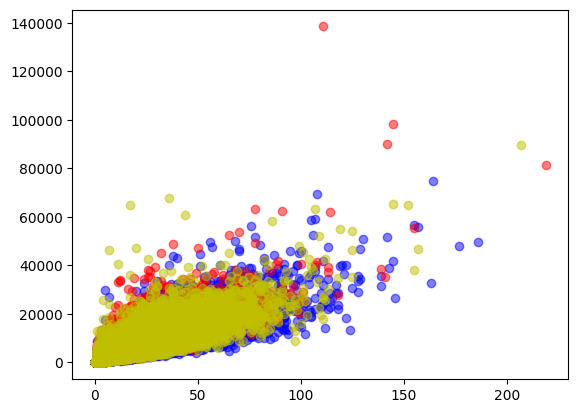

In [ ]:
x1 = df1['Orders_all']
y1 = df1['GFV_all']
x2 = df2['Orders_all']
y2 = df2['GFV_all']
x3 = df3['Orders_all']
y3 = df3['GFV_all']

plt.scatter(x1,y1,c='b',alpha=0.5)
plt.scatter(x2,y2,c='r',alpha=0.5)
plt.scatter(x3,y3,c='y',alpha=0.5)
plt.show()

In [ ]:
x1 = df1['FLGP_all']
y1 = df1['DF_all']
x2 = df2['FLGP_all']
y2 = df2['DF_all']
x3 = df3['FLGP_all']
y3 = df3['DF_all']

plt.scatter(x1,y1,c='b',alpha=0.5)
plt.scatter(x2,y2,c='r',alpha=0.5)
plt.scatter(x3,y3,c='y',alpha=0.5)
plt.show()

In [ ]:
df_a=df.query('city == "Taoyuan" and test_variant == "Control"')
df_a.describe()

In [ ]:
df_b=df.query('city == "Taoyuan" and test_variant == "Variation1"')
df_b.describe()

In [ ]:
df_c=df.query('city == "Taoyuan" and test_variant == "Variation2"')
df_c.describe()